# Data and Library loading

In [ ]:
!apt-add-repository --yes ppa:swi-prolog/stable
!apt-get update
!apt-get install swi-prolog
!apt-get install -y build-essential
!pip install janus_swi
!pip install Texttable
!pip install git+https://github.com/danyvarghese/PyGol.git@main
import pandas as pd

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/swi-prolog/stable/ubuntu/ jammy main'
Description:
Comprehensive Prolog implementation with extensive libraries and development tools.   Primarily targetted at teaching, RDF processing and web-related tasks, such as creating web services or analysing web content.

Official PPAs for SWI-Prolog. See https://www.swi-prolog.org for further information.
More info: https://launchpad.net/~swi-prolog/+archive/ubuntu/stable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/swi-prolog-ubuntu-stable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/swi-prolog-ubuntu-stable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/swi-prolog-ubuntu-stable.gpg with fingerprint E8B739E3753FF4A12360BA6A4AB3A5F60EA9AEB3
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 

In [ ]:
import pandas as pd
movies = pd.read_csv("/content/mldm/data/movies.csv", sep=",")
m2a = pd.read_csv("/content/mldm/data/movies2actors.csv", sep=";")
m2d = pd.read_csv("/content/mldm/data/movies2directors.csv", sep=";")
actors = pd.read_csv("/content/mldm/data/actors.csv", sep=";")
directors = pd.read_csv("/content/mldm/data/directors.csv", sep=";")
u2base = pd.read_csv("/content/mldm/data/u2base.csv", sep=";")
users = pd.read_csv("/content/mldm/data/users.csv", sep=";")

data = []

for data in [actors, directors, movies, m2a, m2d, u2base, users]:
  print(data.columns)

Index(['actorid', 'a_gender', 'a_quality'], dtype='object')
Index(['directorid', 'd_quality', 'avg_revenue'], dtype='object')
Index(['movieid', 'year', 'isEnglish', 'country', 'runningtime'], dtype='object')
Index(['movieid', 'actorid', 'cast_num'], dtype='object')
Index(['movieid', 'directorid', 'genre'], dtype='object')
Index(['userid', 'movieid', 'rating'], dtype='object')
Index(['userid', 'age', 'u_gender', 'occupation'], dtype='object')


In [ ]:
import pandas as pd
import os

#output path for IMDB_merged.csv
output_path = "/content/mldm/data/IMDB_merged.csv"

os.makedirs(os.path.dirname(output_path), exist_ok=True)

#saving 'imdb' DataFrame to CSV file
imdb.to_csv(output_path, index=False)

# EDA

In [ ]:
dataframe_names = ['actors', 'directors', 'movies', 'm2a', 'm2d', 'u2base', 'users']

for df_name in dataframe_names:
    df = globals()[df_name]
    print(f"\nDataFrame: {df_name}")
    for column in df.columns:
        unique_values = df[column].unique()
        # Limit the display of unique values if there are too many
        if len(unique_values) > 20:
            print(f"  Column '{column}': {len(unique_values)} unique values (showing first 20): {unique_values[:20]}")
        else:
            print(f"  Column '{column}': {unique_values}")


DataFrame: actors
  Column 'actorid': 98690 unique values (showing first 20): [   4   16   28  566  580  636  769  797  802  808  817  851  888  894
  923  962  978  989 1143 1276]
  Column 'a_gender': ['M' 'F']
  Column 'a_quality': [4 0 3 2 5 1]

DataFrame: directors
  Column 'directorid': 2201 unique values (showing first 20): [  67   92  284  708  746  836  947 1151 1756 1836 1851 3134 3707 4164
 4451 4621 4637 4930 4997 5049]
  Column 'd_quality': [4 2 3 0 1 5]
  Column 'avg_revenue': [1 3 0 4 2]

DataFrame: movies
  Column 'movieid': 3832 unique values (showing first 20): [1672052 1672111 1672580 1672716 1672946 1673647 1673658 1673848 1674388
 1674737 1677011 1677258 1677346 1677472 1677516 1677631 1678036 1678591
 1679029 1679461]
  Column 'year': [3 4 1 2]
  Column 'isEnglish': ['T' 'F']
  Column 'country': ['other' 'USA' 'France' 'UK']
  Column 'runningtime': [1 0]

DataFrame: m2a
  Column 'movieid': 3798 unique values (showing first 20): [1672052 1672111 1672580 1672716 167

In [ ]:
#Merging tables into 1 dataset

import pandas as pd
import os

#clean up quoted columns in m2d
m2d["genre"] = m2d["genre"].astype(str).str.replace('"', '')

#actor merge
m_a = m2a.merge(actors, on="actorid", how="left")

actor_agg = m_a.groupby("movieid").agg(
    num_actors=("actorid", lambda x: x.nunique()),
    avg_actor_quality=("a_quality", "mean")
).reset_index()

#director merge
m_d = m2d.merge(directors, on="directorid", how="left")

director_agg = m_d.groupby("movieid").agg(
    num_directors=("directorid", lambda x: x.nunique()),
    avg_director_quality=("d_quality", "mean"),
    avg_director_revenue=("avg_revenue", "mean"),
    genres=("genre", lambda x: ", ".join(sorted(set(x.dropna()))))
).reset_index()

#ratings merge
u2base["rating"] = pd.to_numeric(u2base["rating"], errors="coerce")

rating_agg = u2base.groupby("movieid").agg(
    avg_rating=("rating", "mean"),
    num_ratings=("rating", "count")
).reset_index()

#imdb merged
final = (
    movies
    .merge(actor_agg, on="movieid", how="left")
    .merge(director_agg, on="movieid", how="left")
    .merge(rating_agg, on="movieid", how="left")
)

#save file
output_path = "/content/mldm/data/IMDB_merged.csv"

os.makedirs(os.path.dirname(output_path), exist_ok=True)

final.to_csv(output_path, index=False)

output_path

'/content/mldm/data/IMDB_merged.csv'

In [ ]:
#print values in columns
import pandas as pd
imdb = pd.read_csv("/content/mldm/data/IMDB_merged.csv")
print(f"\nimdb")
for column in imdb.columns:
    unique_values = imdb[column].unique()
    if len(unique_values) > 20:
        print(f"  Column '{column}': {len(unique_values)} unique values ")
    else:
        print(f"  Column '{column}': {unique_values}")


DataFrame: imdb
  Column 'movieid': 3832 unique values 
  Column 'year': [3 4 1 2]
  Column 'isEnglish': ['T' 'F']
  Column 'country': ['other' 'USA' 'France' 'UK']
  Column 'runningtime': [1 0]
  Column 'num_actors': 148 unique values 
  Column 'avg_actor_quality': 1210 unique values 
  Column 'num_directors': [ 1.  2.  3.  4.  7.  6. nan 11.  8.  5.]
  Column 'avg_director_quality': [3.         2.         4.         0.         1.         3.33333333
 5.         2.5        3.5               nan 3.66666667 3.25
 3.875      3.75       2.33333333 3.8       ]
  Column 'avg_director_revenue': 28 unique values 
  Column 'genres': ['Drama' 'Action' 'Comedy' 'Adventure' 'Documentary' 'Other' 'Horror'
 'Crime' 'Animation' nan]
  Column 'avg_rating': 2736 unique values 
  Column 'num_ratings': 927 unique values 


In [ ]:
#creating is_a_hit columns
median_ratings = imdb['num_ratings'].median()
imdb['is_a_hit'] = (imdb['num_ratings'] > median_ratings).astype(int)

In [ ]:
#mapping of num_actors
median_actors = imdb['num_actors'].median()
imdb['number_actors'] = imdb['num_actors'].apply(lambda x: 'few' if x < median_actors else 'many')
print(imdb[['num_actors', 'number_actors']].tail())

      num_actors number_actors
3827        17.0           few
3828        36.0          many
3829        10.0           few
3830        43.0          many
3831        29.0           few


In [ ]:
#mapping of avg_actor_quality
median_actor_qual = imdb['avg_actor_quality'].median()
imdb['actor_quality'] = imdb['avg_actor_quality'].apply(lambda x: 'low' if x < median_actor_qual else 'high')
print(imdb[['avg_actor_quality', 'actor_quality']].head())

   avg_actor_quality actor_quality
0           3.976190          high
1           3.068966           low
2           2.706897           low
3           3.875000          high
4           0.000000           low


In [ ]:
#mapping of avg_director_quality
median_director_qual = imdb['avg_director_quality'].median()
imdb['director_quality'] = imdb['avg_director_quality'].apply(lambda x: 'low' if x < median_director_qual else 'high')
print(imdb[['avg_director_quality', 'director_quality']].tail())

      avg_director_quality director_quality
3827                   4.0             high
3828                   3.0              low
3829                   4.0             high
3830                   4.0             high
3831                   4.0             high


In [ ]:
imdb['director_quality'].value_counts()

,count
director_quality,
high,1932
low,1900


In [ ]:
median_director_rev = imdb['avg_director_revenue'].median()
median_director_rev

3.0

In [ ]:
#mapping of avg_director_revenue
median_director_rev = imdb['avg_director_revenue'].median()
imdb['director_revenue'] = imdb['avg_director_revenue'].apply(lambda x: 'low' if x < median_director_rev else 'high')
print(imdb[['avg_director_revenue', 'director_revenue']].head())

   avg_director_revenue director_revenue
0                   4.0             high
1                   4.0             high
2                   2.0              low
3                   1.0              low
4                   0.0              low


In [ ]:
imdb['director_revenue'].value_counts()

,count
director_revenue,
high,2051
low,1781


In [ ]:
import numpy as np
#discretization for number of directors
#if 1 director then 'single'; if >1 director then 'multiple'
new_col_name = 'director_number'
imdb[new_col_name] = np.where(imdb['num_directors'] == 1, 'single', 'multiple')

In [ ]:
import numpy as np
#discretization for runtime
new_col_name = 'run_time'
imdb[new_col_name] = np.where(imdb['runningtime'] == 1, 'long', 'short')

In [ ]:
import pandas as pd
imdb.drop(columns=['runningtime'], inplace = True)

In [ ]:
import pandas as pd
imdb = pd.read_csv("/content/mldm/data/IMDB_merged.csv")
imdb.drop(columns=['avg_actor_quality', 'num_actors', 'num_directors', 'avg_director_quality', 'avg_director_revenue'], inplace = True)

In [ ]:
imdb.isna().sum()

,0
movieid,0
year,0
isEnglish,0
country,0
runningtime,0
genres,0
avg_rating,0
num_ratings,0
is_a_hit,0
number_actors,0


In [ ]:
imdb.dropna(subset=['genres', 'avg_rating', 'num_ratings'], inplace=True)

In [ ]:
import pandas as pd
imdb = pd.read_csv("/content/mldm/data/IMDB_merged.csv")
#checking value counts for each column
def get_value_counts_for_all_columns(dataframe):
    for column in imdb.columns:
        print(f"\n--- Value Counts for Column: {column} ---")
        print(dataframe[column].value_counts(dropna=False))

get_value_counts_for_all_columns(imdb)


--- Value Counts for Column: movieid ---
movieid
2593313    1
1672052    1
1672111    1
1672580    1
1672716    1
          ..
1679461    1
1679029    1
1678591    1
1678036    1
1677631    1
Name: count, Length: 3646, dtype: int64

--- Value Counts for Column: year ---
year
4    2593
3     732
2     288
1      33
Name: count, dtype: int64

--- Value Counts for Column: isEnglish ---
isEnglish
T    3278
F     368
Name: count, dtype: int64

--- Value Counts for Column: country ---
country
USA       2640
other      467
UK         361
France     178
Name: count, dtype: int64

--- Value Counts for Column: genres ---
genres
Comedy         1138
Drama           859
Action          552
Crime           271
Adventure       270
Documentary     217
Horror          211
Other            84
Animation        44
Name: count, dtype: int64

--- Value Counts for Column: avg_rating ---
avg_rating
3.000000    86
4.000000    60
2.000000    57
3.500000    38
1.000000    31
            ..
3.526393     1
3.4918

In [ ]:
#move 'is_a_hit' to the end
imdb = imdb[[col for col in imdb.columns if col != 'is_a_hit'] + ['is_a_hit']]
imdb

,movieid,year,isEnglish,country,genres,avg_rating,num_ratings,number_actors,actor_quality,director_quality,director_revenue,director_number,run_time,is_a_hit
0,1672052,3,T,other,Drama,4.102778,360.0,many,high,low,high,single,long,1
1,1672111,4,T,other,Action,2.628019,414.0,many,low,low,high,single,long,1
2,1672580,4,T,USA,Comedy,2.692308,52.0,many,low,low,low,single,long,0
3,1672716,4,T,USA,Drama,3.371429,70.0,few,high,high,low,single,long,0
4,1672946,4,T,USA,Action,3.713568,199.0,few,low,low,low,single,short,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,2591814,4,T,other,Other,3.256098,410.0,few,high,high,high,single,long,1
3642,2592334,4,T,USA,Adventure,3.117750,569.0,many,low,low,high,single,long,1
3643,2592963,2,F,France,Comedy,3.761905,21.0,few,high,high,low,single,long,0
3644,2593112,4,T,USA,Comedy,4.187500,16.0,many,high,high,low,single,short,0


In [ ]:
imdb['is_a_hit'].value_counts()

,count
is_a_hit,
0,1826
1,1820


In [ ]:
import pandas as pd
imdb = pd.read_csv("/content/mldm/data/IMDB_merged.csv")

#convert values in 'genres' and 'country' columns to lowercase
imdb['genres'] = imdb['genres'].str.lower()
imdb['country'] = imdb['country'].str.lower()

print(imdb[['genres', 'country']].head())

   genres country
0   drama   other
1  action   other
2  comedy     usa
3   drama     usa
4  action     usa


Text(0.5, 1.0, 'Distribution of Movie Hits vs Non-Hits')

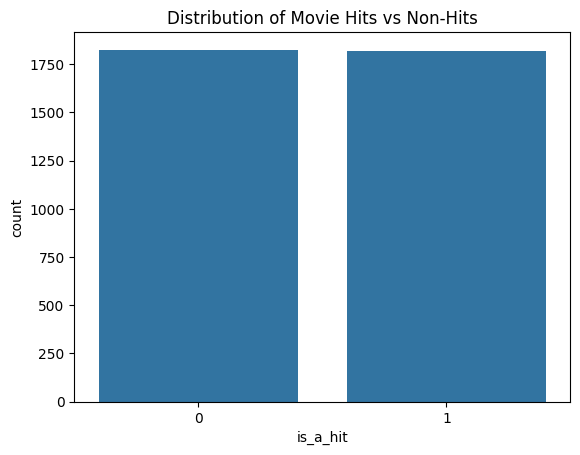

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("/content/mldm/ILP/data/IMDB_merged.csv")
sns.countplot(data=df, x="is_a_hit")
plt.title("Distribution of Movie Hits vs Non-Hits")

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'comedy'),
  Text(1, 0, 'drama'),
  Text(2, 0, 'action'),
  Text(3, 0, 'crime'),
  Text(4, 0, 'adventure'),
  Text(5, 0, 'documentary'),
  Text(6, 0, 'horror'),
  Text(7, 0, 'other'),
  Text(8, 0, 'animation')])

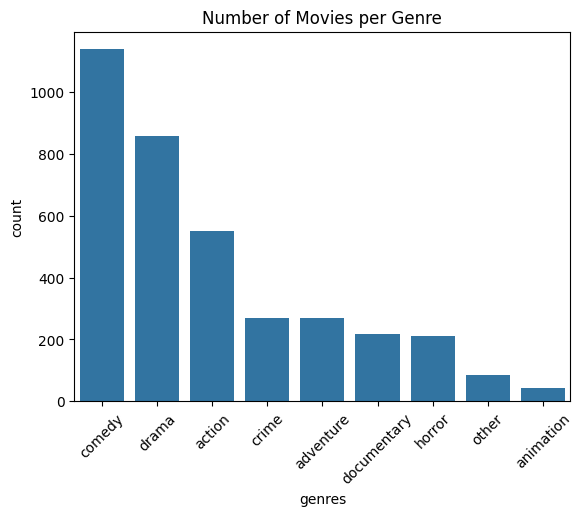

In [ ]:
sns.countplot(data=df, x="genres", order=df['genres'].value_counts().index)
plt.title("Number of Movies per Genre")
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Movie Success by Number of Directors')

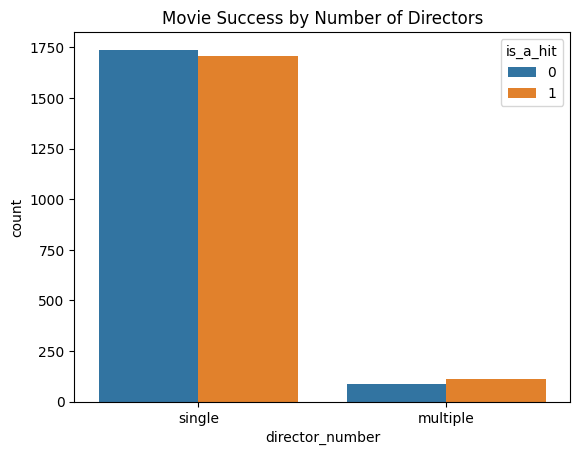

In [ ]:
sns.countplot(data=df, x="director_number", hue="is_a_hit")
plt.title("Movie Success by Number of Directors")

Text(0.5, 1.0, 'Proportion of Hits by Director Quality')

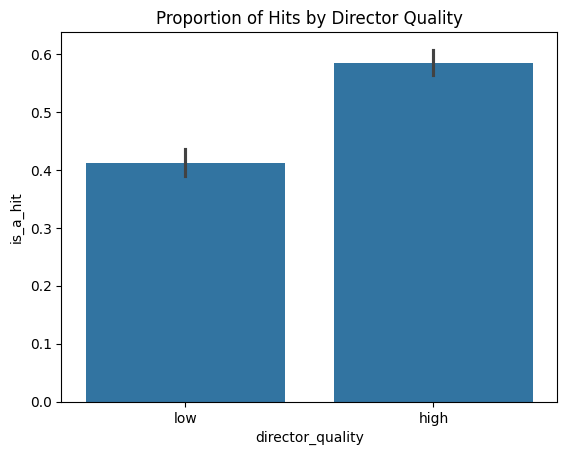

In [ ]:
sns.barplot(data=df, x="director_quality", y="is_a_hit", estimator=np.mean)
plt.title("Proportion of Hits by Director Quality")

Text(0.5, 1.0, 'Hit Rate by Year Group')

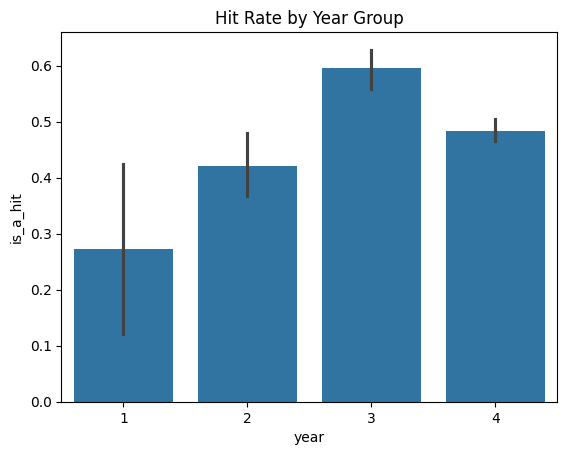

In [ ]:
sns.barplot(data=df, x="year", y="is_a_hit", estimator=np.mean)
plt.title("Hit Rate by Year Group")

Text(0.5, 1.0, 'Correlation of Features with Movie Hit Status')

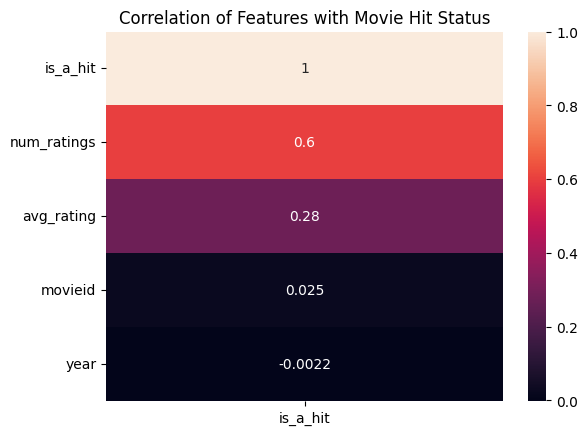

In [ ]:
corr = df.select_dtypes(include=['int', 'float']).corr()
sns.heatmap(corr[['is_a_hit']].sort_values(by='is_a_hit', ascending=False), annot=True)
plt.title("Correlation of Features with Movie Hit Status")

# PyGol

In [ ]:
imdb = pd.read_csv("/content/mldm/data/IMDB_merged.csv")
imdb

,movieid,year,isEnglish,country,genres,avg_rating,num_ratings,number_actors,actor_quality,director_quality,director_revenue,director_number,run_time,is_a_hit
0,1672052,3,english,other,drama,4.102778,360.0,many,high,low,high,single,long,1
1,1672111,4,english,other,action,2.628019,414.0,many,low,low,high,single,long,1
2,1672580,4,english,usa,comedy,2.692308,52.0,many,low,low,low,single,long,0
3,1672716,4,english,usa,drama,3.371429,70.0,few,high,high,low,single,long,0
4,1672946,4,english,usa,action,3.713568,199.0,few,low,low,low,single,short,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,2591814,4,english,other,other,3.256098,410.0,few,high,high,high,single,long,1
3642,2592334,4,english,usa,adventure,3.117750,569.0,many,low,low,high,single,long,1
3643,2592963,2,non_english,france,comedy,3.761905,21.0,few,high,high,low,single,long,0
3644,2593112,4,english,usa,comedy,4.187500,16.0,many,high,high,low,single,short,0


In [ ]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../../')
from PyGol import *
data = pd.read_csv("/content/mldm/data/IMDB_merged.csv")
#selecting Feature Columns for PyGol
feature_col=data.columns[1:-1]
## Selecting Target Columns for PyGol
target=data.columns[-1]

#selecting data and target
X = data.values[:,1:-1]
y = data.values[:,-1]

In [ ]:
print(feature_col)
print(target)

Index(['year', 'isEnglish', 'country', 'genres', 'avg_rating', 'num_ratings',
       'number_actors', 'actor_quality', 'director_quality',
       'director_revenue', 'director_number', 'run_time'],
      dtype='object')
is_a_hit


change default_div, look at conditions: conditions={'avg_rating':20})

In [ ]:
background=prepare_logic_rules(data,feature_col, meta_information="meta_data.info", default_div=10, conditions={})
examples=prepare_examples(data,target)
const=read_constants_meta_info()

P, N = bottom_clause_generation(file="BK.pl", constant_set = const,  container = "dict",
                                positive_example="pos_example.f", negative_example="neg_example.n")


Train_P, Test_P, Train_N, Test_N=pygol_train_test_split(test_size=0.50,
                                                        positive_file_dictionary=P,
                                                        negative_file_dictionary=N)

100%|██████████| 1820/1820 [00:53<00:00, 33.92it/s]


check max_literals and increase value; check min_pos and max_neg

In [ ]:

model= pygol_learn(Train_P, Train_N, max_literals=2, exact_literals=True,
                    key_size=1, min_pos=2, max_neg=170)


100%|██████████| 910/910 [00:06<00:00, 140.73it/s]


+----------+ Hypothesis +----------+
['target(A):-director_number(A,single),num_ratings(A,g0)', 'target(A):-genres(A,adventure),num_ratings(A,g1)', 'target(A):-avg_rating(A,g9),num_ratings(A,g1)', 'target(A):-avg_rating(A,g5),director_number(A,multiple)', 'target(A):-avg_rating(A,g1),director_number(A,multiple)', 'target(A):-country(A,france),director_number(A,multiple)', 'target(A):-genres(A,animation),num_ratings(A,g1)', 'target(A):-avg_rating(A,g2),director_number(A,multiple)', 'target(A):-genres(A,documentary),year(A,2)', 'target(A):-avg_rating(A,g0),year(A,2)', 'target(A):-country(A,other),director_number(A,multiple)', 'target(A):-director_number(A,multiple),genres(A,documentary)', 'target(A):-avg_rating(A,g4),genres(A,horror)', 'target(A):-genres(A,action),year(A,2)', 'target(A):-avg_rating(A,g0),director_number(A,multiple)', 'target(A):-avg_rating(A,g2),genres(A,crime)', 'target(A):-director_number(A,multiple),genres(A,drama)', 'target(A):-avg_rating(A,g0),country(A,uk)', 'targe

In [ ]:

metrics=evaluate_theory_prolog(model.hypothesis,"BK.pl",Test_P, Test_N)

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|      n = 1823       | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 816              | 72               |
+---------------------+------------------+------------------+
| Negative(Predicted) | 97               | 838              |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.907 |
+-------------+-------+
| Precision   | 0.919 |
+-------------+-------+
| Sensitivity | 0.894 |
+-------------+-------+
| Specificity | 0.921 |
+-------------+-------+
| F1 Score    | 0.906 |
+-------------+-------+


In [ ]:
for rule in model.hypothesis:
  print(rule)

target(A):-director_number(A,single),num_ratings(A,g0)
target(A):-genres(A,adventure),num_ratings(A,g1)
target(A):-avg_rating(A,g9),num_ratings(A,g1)
target(A):-avg_rating(A,g5),director_number(A,multiple)
target(A):-avg_rating(A,g1),director_number(A,multiple)
target(A):-country(A,france),director_number(A,multiple)
target(A):-genres(A,animation),num_ratings(A,g1)
target(A):-avg_rating(A,g2),director_number(A,multiple)
target(A):-genres(A,documentary),year(A,2)
target(A):-avg_rating(A,g0),year(A,2)
target(A):-country(A,other),director_number(A,multiple)
target(A):-director_number(A,multiple),genres(A,documentary)
target(A):-avg_rating(A,g4),genres(A,horror)
target(A):-genres(A,action),year(A,2)
target(A):-avg_rating(A,g0),director_number(A,multiple)
target(A):-avg_rating(A,g2),genres(A,crime)
target(A):-director_number(A,multiple),genres(A,drama)
target(A):-avg_rating(A,g0),country(A,uk)
target(A):-avg_rating(A,g6),genres(A,documentary)
target(A):-avg_rating(A,g2),country(A,france)
ta